In [1]:
!pip install kaggle
!mkdir -p /root/.kaggle
!scp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d abrambeyer/openintro-possum

Dataset URL: https://www.kaggle.com/datasets/abrambeyer/openintro-possum
License(s): CC0-1.0
  0% 0.00/2.15k [00:00<?, ?B/s]
100% 2.15k/2.15k [00:00<00:00, 4.85MB/s]


In [2]:
!unzip openintro-possum.zip -d possum_data

Archive:  openintro-possum.zip
  inflating: possum_data/possum.csv  


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, mean_squared_error, auc
from sklearn.metrics import mean_absolute_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset

# Загрузка данных
data = pd.read_csv("possum_data/possum.csv")

print('possum.csv before cleansing:\n')
# Чекаем инфу
print(data.shape)
data.info()
display(data.head())
print(data.columns)
data.isna().sum()

possum.csv before cleansing:

(104, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   case      104 non-null    int64  
 1   site      104 non-null    int64  
 2   Pop       104 non-null    object 
 3   sex       104 non-null    object 
 4   age       102 non-null    float64
 5   hdlngth   104 non-null    float64
 6   skullw    104 non-null    float64
 7   totlngth  104 non-null    float64
 8   taill     104 non-null    float64
 9   footlgth  103 non-null    float64
 10  earconch  104 non-null    float64
 11  eye       104 non-null    float64
 12  chest     104 non-null    float64
 13  belly     104 non-null    float64
dtypes: float64(10), int64(2), object(2)
memory usage: 11.5+ KB


,case,site,Pop,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
0,1,1,Vic,m,8.0,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0
1,2,1,Vic,f,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0
2,3,1,Vic,f,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0
3,4,1,Vic,f,6.0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0
4,5,1,Vic,f,2.0,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0


Index(['case', 'site', 'Pop', 'sex', 'age', 'hdlngth', 'skullw', 'totlngth',
       'taill', 'footlgth', 'earconch', 'eye', 'chest', 'belly'],
      dtype='object')


,0
case,0
site,0
Pop,0
sex,0
age,2
hdlngth,0
skullw,0
totlngth,0
taill,0
footlgth,1


In [4]:
# Удаление строк с пропущенными значениями
data.dropna(inplace=True)

print('possum.csv after cleansing:\n')
print(data.shape)
data.info()
data.isna().sum()

possum.csv after cleansing:

(101, 14)
<class 'pandas.core.frame.DataFrame'>
Index: 101 entries, 0 to 103
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   case      101 non-null    int64  
 1   site      101 non-null    int64  
 2   Pop       101 non-null    object 
 3   sex       101 non-null    object 
 4   age       101 non-null    float64
 5   hdlngth   101 non-null    float64
 6   skullw    101 non-null    float64
 7   totlngth  101 non-null    float64
 8   taill     101 non-null    float64
 9   footlgth  101 non-null    float64
 10  earconch  101 non-null    float64
 11  eye       101 non-null    float64
 12  chest     101 non-null    float64
 13  belly     101 non-null    float64
dtypes: float64(10), int64(2), object(2)
memory usage: 11.8+ KB


,0
case,0
site,0
Pop,0
sex,0
age,0
hdlngth,0
skullw,0
totlngth,0
taill,0
footlgth,0


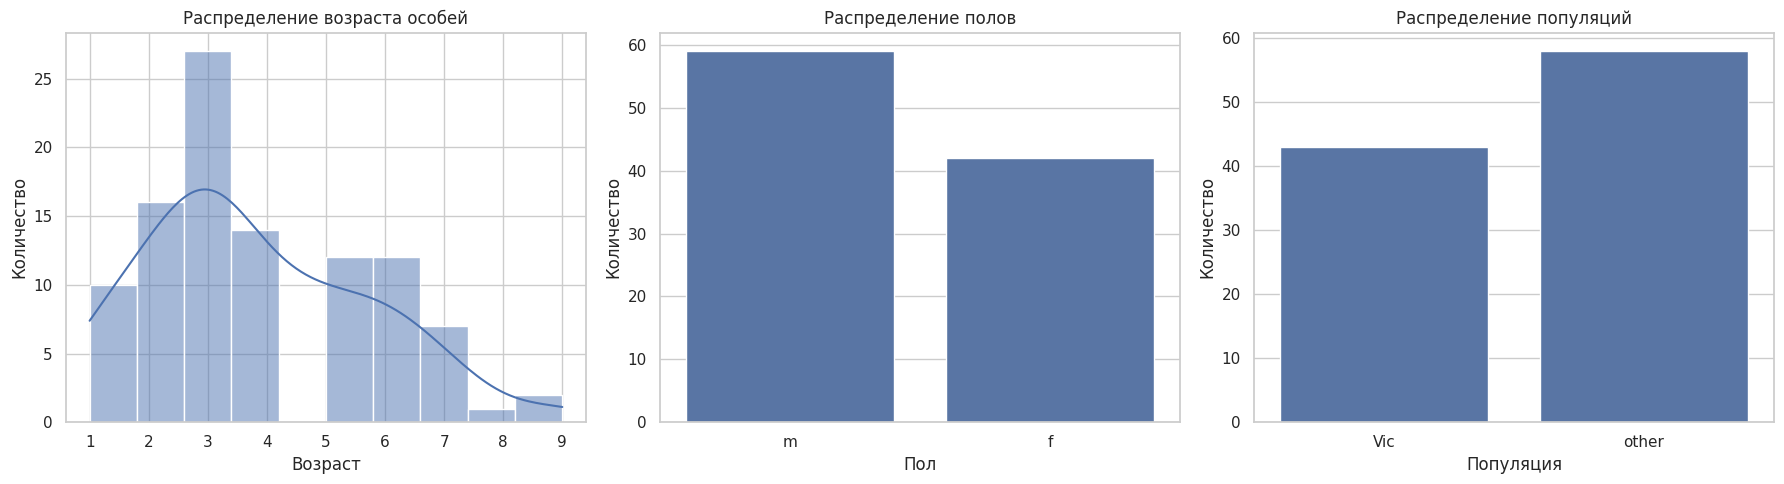

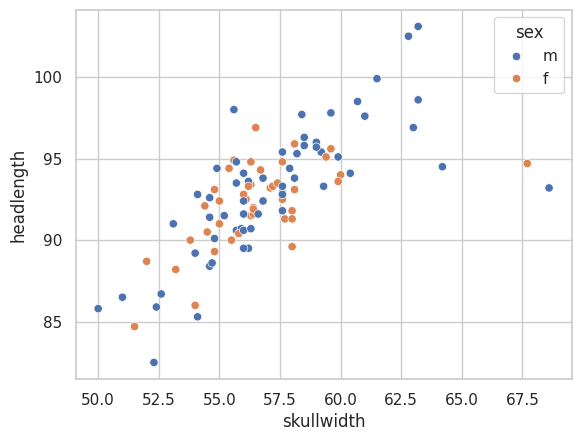

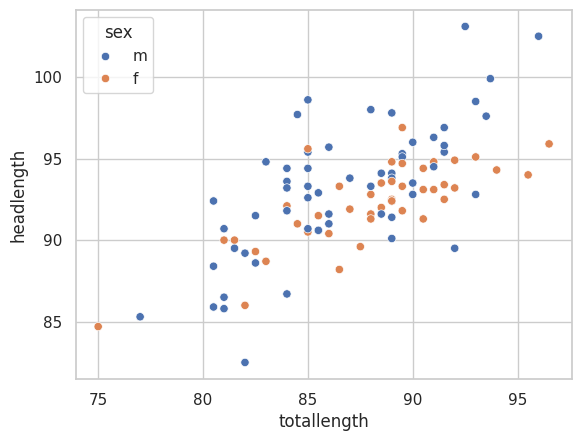

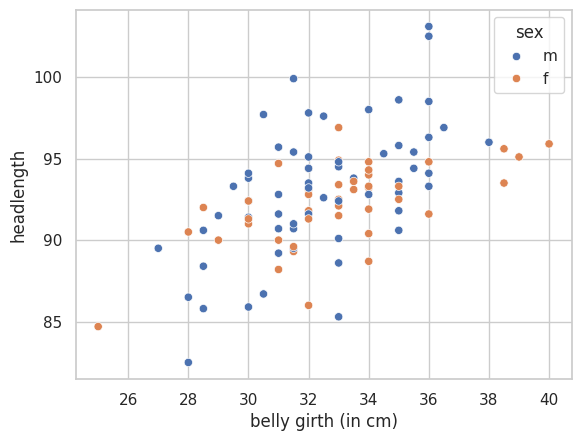

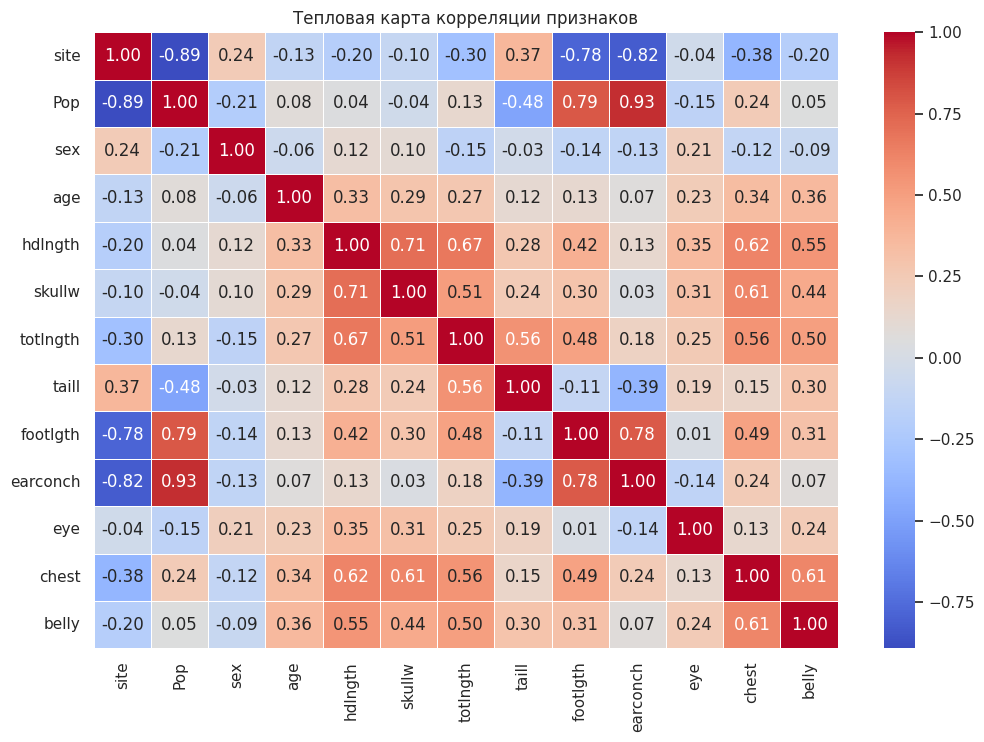

In [5]:
# Установка стиля для графиков
sns.set(style="whitegrid")

# Фигура для визуализаций
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# График распределения возраста
sns.histplot(data['age'], bins=10, kde=True, ax=axes[0])
axes[0].set_title('Распределение возраста особей')
axes[0].set_xlabel('Возраст')
axes[0].set_ylabel('Количество')

# График распределения полов
sns.countplot(x='sex', data=data, ax=axes[1])
axes[1].set_title('Распределение полов')
axes[1].set_xlabel('Пол')
axes[1].set_ylabel('Количество')

# График распределения популяций
sns.countplot(x='Pop', data=data, ax=axes[2])
axes[2].set_title('Распределение популяций')
axes[2].set_xlabel('Популяция')
axes[2].set_ylabel('Количество')

# Отображение графиков
plt.tight_layout()
plt.show()

sns.scatterplot(data=data, x='skullw', y='hdlngth', hue='sex')
plt.xlabel('skullwidth')
plt.ylabel('headlength')
plt.show()

sns.scatterplot(data=data, x='totlngth', y='hdlngth', hue='sex')
plt.xlabel('totallength')
plt.ylabel('headlength')
plt.show()

sns.scatterplot(data=data, x='belly', y='hdlngth', hue='sex')
plt.xlabel('belly girth (in cm)')
plt.ylabel('headlength')
plt.show()

# получение данных для тепловой карты корр
heat_map_data = data.drop(columns=['case'])
heat_map_data["sex"] = [1 if i == "m" else 0 for i in data["sex"]]
heat_map_data["Pop"] = [1 if i == "Vic" else 0 for i in data["Pop"]]
#print(heat_map_data['sex'].dtype)

# Тепловая карта корреляции
plt.figure(figsize=(12, 8))
sns.heatmap(heat_map_data.corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title('Тепловая карта корреляции признаков')
plt.show()


Accuracy: 0.6667
F1 Score: 0.6957
ROC-AUC: 0.7407


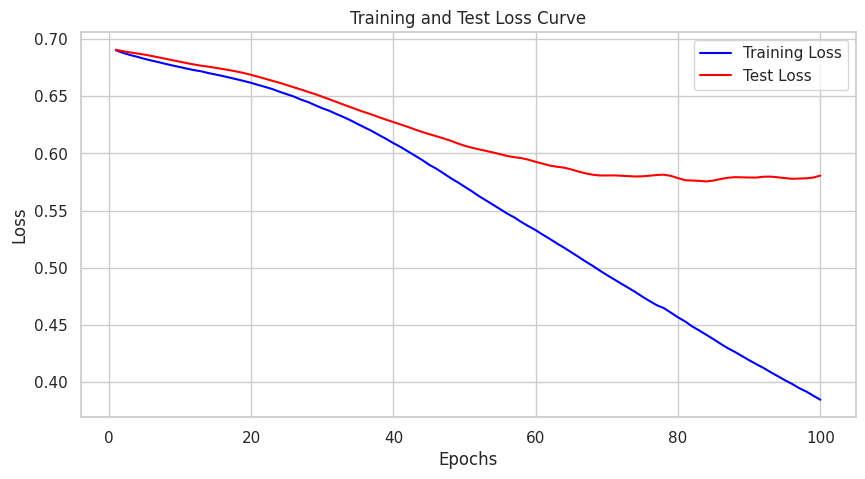

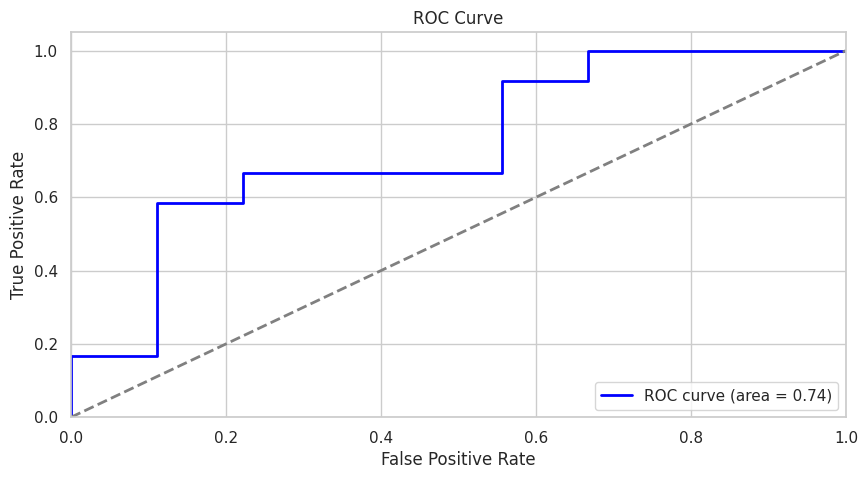

In [ ]:
X = data.drop(columns=['sex', 'case', 'Pop'])  # Признаки
y = data['sex']  # Целевая переменная

# Кодирование целевой переменной
le = LabelEncoder()
y = le.fit_transform(y)  # Преобразуем 'male'/'female' в 1/0

# Масштабирование признаков
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Преобразование в тензоры
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Создание DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Определение модели
class PossumClassifier(nn.Module):
    def __init__(self, input_dim):
        super(PossumClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Инициализация модели, функции потерь и оптимизатора
input_dim = X_train.shape[1]
model = PossumClassifier(input_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Функция обучения
def train_model(model, train_loader, criterion, optimizer, num_epochs=100):
    model.train()
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * inputs.size(0)
        epoch_loss /= len(train_loader.dataset)
        train_losses.append(epoch_loss)

        # Оценка loss на тестовой выборке
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels)
                test_loss += loss.item() * inputs.size(0)
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)
        model.train()

        #print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Test Loss: {test_loss:.4f}')

    return train_losses, test_losses


# Функция оценки модели
def evaluate_model(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs).squeeze()
            preds = (outputs >= 0.5).float()
            all_labels.extend(labels.numpy())
            all_preds.extend(outputs.numpy())
    accuracy = accuracy_score(all_labels, (np.array(all_preds) >= 0.5).astype(int))
    f1 = f1_score(all_labels, (np.array(all_preds) >= 0.5).astype(int))
    roc_auc = roc_auc_score(all_labels, all_preds)
    return accuracy, f1, roc_auc, all_labels, all_preds

# Обучение модели
train_losses, test_losses = train_model(model, train_loader, criterion, optimizer)

# Оценка модели
accuracy, f1, roc_auc, all_labels, all_preds = evaluate_model(model, test_loader)
print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC-AUC: {roc_auc:.4f}')

# Визуализация кривой обучения
plt.figure(figsize=(10, 5))
plt.plot(range(1, 101), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, 101), test_losses, label='Test Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()
plt.show()


# Визуализация ROC-кривой
fpr, tpr, thresholds = roc_curve(all_labels, all_preds)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


MSE on test data: 3.5740
MAE on test data: 1.4409
R^2 on test data: 0.7272


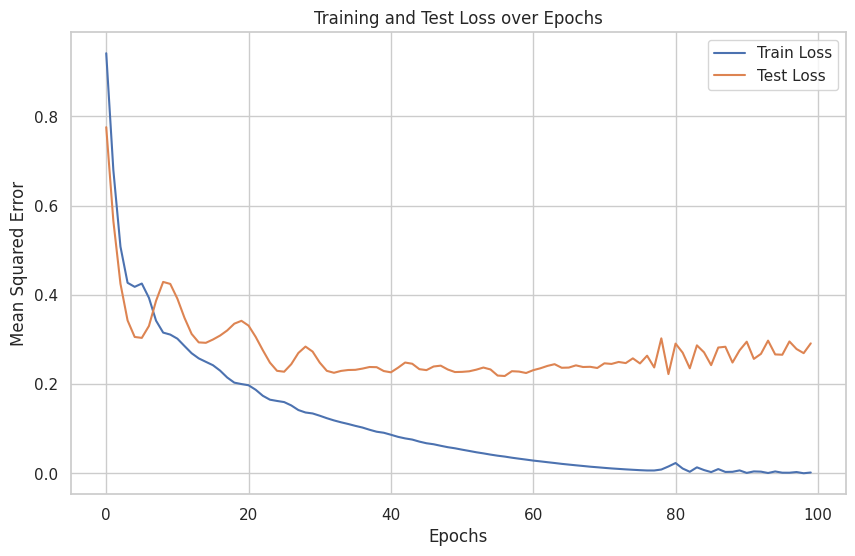

In [ ]:
# Выбор признаков и целевой переменной
X = data.drop(columns=['site', 'Pop', 'sex', 'age', 'hdlngth'])
y = data['hdlngth']

# Преобразование категориальных признаков
X = pd.get_dummies(X, drop_first=True)

# Масштабирование признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Нормализация целевой переменной
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Преобразование данных в тензоры
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Определение модели
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def train_model(model, X_train, y_train, X_test, y_test, num_epochs=100, lr=0.01):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        model.train()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            test_losses.append(test_loss.item())

        #if (epoch+1) % 10 == 0:
            #print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

    return train_losses, test_losses

def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test).numpy()  # Предсказания модели
        predictions = scaler_y.inverse_transform(predictions)  # Обратное преобразование
        y_test_original = scaler_y.inverse_transform(y_test)  # Обратное преобразование истинных значений
        mse = mean_squared_error(y_test_original, predictions)
        mae = mean_absolute_error(y_test_original, predictions)
        r2 = r2_score(y_test_original, predictions)
        print(f'MSE on test data: {mse:.4f}')
        print(f'MAE on test data: {mae:.4f}')
        print(f'R^2 on test data: {r2:.4f}')
        return mse, mae, r2, predictions

model = RegressionModel(X_train_tensor.shape[1])
train_losses, test_losses = train_model(model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor)
evaluate_model(model, X_test_tensor, y_test)

plt.figure(figsize=(10, 6))
plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(len(test_losses)), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Training and Test Loss over Epochs')
plt.legend()
plt.show()
